## Track Statistics (Slope, Starting coordinate, Ending coordinate)

This program calculates the track slope by taking the best fit line. Here we have considered 2 approaches towards taking the best fit line. 

In the first approach, only the catesian coordinates of the pixels have been used to plot the line. But in the second approach, we have also included the information about the intensities of the pixels. And it is clear that we get a better prediction of slopes by using the second approach. By using the first method, we were actually destroying the extra information (about intensity values) which turned out to be crucial in getting a better estimate of the slope.

In [8]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from scipy import misc
import imageio
from sklearn.metrics import auc
from sklearn import metrics
import math
import random
from scipy import stats
import sklearn
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle 

In [9]:
pi=math.pi
tan=math.tan
cos=math.cos
sin=math.sin
exp=math.exp
sqrt=math.sqrt

In [10]:
image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
freq_min=20
freq_max=image.shape[1]
t_min=20
t_max=image.shape[0]
mean_life=15

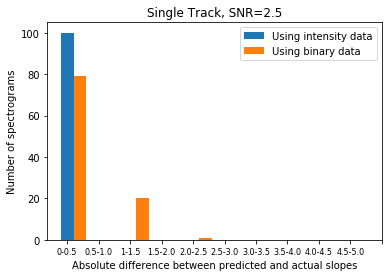

54.225717306137085 seconds


In [72]:
fig=100
accuracy_hist=[]
start=time.time()
hist_intensities=[]
hist_binary=[]
for N in range(fig):

    pixel_threshold=5
    angle_dim=100
    window_size=10
    n_std=2.1
    th_consecutive=3
    max_spacing=25
    
    w0=random.randint(freq_min,25)
    t0=random.randint(t_min,25)
    
    alpha=random.uniform(1.222,1.484)
    SNR=2.5
    sigma=0.5

    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)
    pixel_gray=get_gray(pixel)
    th_true=np.mean(pixel)+np.std(pixel)
    binary_gray=get_binary_gray(pixel_gray,th_true)
    img=get_pixel_new(pixel_gray)

    binary_img, binary_final,slope_avg = local_hough_track_reconstruction_with(img, window_size, angle_dim, pixel_threshold, n_std,th_consecutive,max_spacing)
    
    start_x,start_y,end_x,end_y=get_track_stats(binary_final,window_size)
    spec_final=get_spec_final(binary_final,img)
    
    for track in range(len(start_x)):
        window_binary=binary_final[start_x[track]-5:end_x[track]+5,start_y[track]-5:end_y[track]+5]
        window_intensity=spec_final[start_x[track]-5:end_x[track]+5,start_y[track]-5:end_y[track]+5]
        slope_binary=get_best_fit_binary(window_binary)
        slope_intensity=get_best_fit_intensities(window_intensity)
        if(slope_binary==-1 or slope_intensity==-1):continue
        diff_binary=int(abs((90-np.degrees(alpha))-slope_binary))
        diff_intensity=int(abs((90-np.degrees(alpha))-slope_intensity))
        if(diff_binary<=5 or diff_intensity<=5):
            hist_binary.append(int(diff_binary/0.5))
            hist_intensities.append(int(diff_intensity/0.5))

plt.hist([hist_intensities,hist_binary],bins =[0,1,2,3,4,5,6,7,8,9],label=['Using intensity data','Using binary data'])
x = np.array([0.3,1.3,2.3,3.3,4.3,5.3,6.3,7.3,8.3,9.3,10.3])
my_xticks = ['0-0.5','0.5-1.0','1-1.5','1.5-2.0','2.0-2.5','2.5-3.0','3.0-3.5','3.5-4.0','4.0-4.5','4.5-5.0']
plt.xticks(x,my_xticks,fontsize=8)
plt.xlabel("Absolute difference between predicted and actual slopes")
plt.ylabel("Number of spectrograms")
plt.title("Single Track, SNR=2.5")
plt.legend(loc='upper right')
plt.show()

end = time.time()
print(end-start, "seconds")

In [44]:
def get_spec_final(binary_final,img):
    spec_final=np.zeros(shape=(img.shape[0],img.shape[1]))
    for i in range(binary_final.shape[0]):
        for j in range(binary_final.shape[1]):
            if(binary_final[i,j]==True):
                spec_final[i,j]=img[i,j]
    return spec_final

In [59]:
def get_best_fit_intensities(window):
    x_pts=[]
    y_pts=[]
    num=0
    den=0
    sum=0
    for i in range(window.shape[0]):
        for j in range(window.shape[1]):
            if(window[i,j]>0):
                x_pts.append(i)
                y_pts.append(j)
                
    if(len(x_pts)==0 or len(y_pts)==0):
        return -1  
    else:
        mean_x=np.mean(x_pts)
        mean_y=np.mean(y_pts)
    
        for i in range(len(x_pts)):
            sum=sum+window[x_pts[i],y_pts[i]]
        I_avg=sum/len(x_pts)
        
        for n in range(len(x_pts)):
            num=num+(window[x_pts[n],y_pts[n]]**2)*(x_pts[n]-mean_x)*(y_pts[n]-mean_y)
        for n in range(len(x_pts)):
            den=den+(window[x_pts[n],y_pts[n]]**2)*(y_pts[n]-mean_y)**2
        slope=num/den
    return np.degrees(math.atan(slope))

In [43]:
def get_best_fit_binary(window):
    best_fit_matrix_x=[]
    best_fit_matrix_y=[]
    for x in range(window.shape[0]-1):
         for y in range(window.shape[1]-1):
                if(window[x,y]==True):
                    best_fit_matrix_x.append(y)
                    best_fit_matrix_y.append(x)
    if(len(best_fit_matrix_x)==0 or len(best_fit_matrix_y)==0):
        return -1
    else:
        m, b = np.polyfit(best_fit_matrix_x,best_fit_matrix_y, 1)
        return(np.degrees(m))

In [13]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    
    scatter_time=t_prev+30 #Scattering times follow an exponential distribution
    scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
            
    ybar=freq_prev
    xbar=t_prev
    
    for i in range(t_prev,scatter_time):
        for j in range(freq_prev,scatter_freq):
            intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
            image[j,i]=(intensity,intensity,0)
                
    t_prev=scatter_time+3
    freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    #print("Time:get_image()",end-start)
    return image

In [14]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [15]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
   # print("Time:get_gray()",end-start)
    return pixel_gray

In [16]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
   # print("Time:get_binary_gray",end-start)
    return binary_gray

In [17]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
   # print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [18]:
def get_voting(img, xx, yy, window, angles):
    
    result=xx*np.cos(angles[:,None,None])+yy*np.sin(angles[:,None,None])

    voting_matrix = np.zeros(shape=result.shape, dtype=bool)
    
    bool_mask = window[None,:,:]&(np.abs(result)<0.5)

    voting_matrix[bool_mask]=1
    
    return voting_matrix

In [19]:
def get_local_result(binary_result, pixel_threshold):
    
    hist = np.sum(binary_result,axis=(1,2))
    #plt.plot(hist)
    #plt.show()
    result_angles = hist>pixel_threshold
    #print(result_angles)
   # print(np.any(binary_result[result_angles],axis=0))
    angle_total=len(result_angles)
    slope_local_sum=0
    count_local=0
    i=0
    if(np.sum(result_angles)>0):
        increment=90/(angle_total-1)
        while(i<angle_total):
            if(result_angles[i]==True):
                slope_local_sum=slope_local_sum+(i*increment)
                count_local=count_local+1
            i=i+1
        slope_local_avg=slope_local_sum/count_local
            
    else:
        slope_local_avg=0
    #print(slope_local_avg)

    return np.any(binary_result[result_angles],axis=0),slope_local_avg

In [20]:
def get_window_centers(binary_img, width):
    ind = np.argwhere(binary_img)
    ind_c=(ind[:,0]>=width)&(ind[:,0]<binary_img.shape[0]-width)&\
            (ind[:,1]>=width)&(ind[:,1]<binary_img.shape[1]-width)
    ind = ind[ind_c]
    return ind

In [21]:
def get_binary_img(img,n_std):
    threshold = np.mean(img)+n_std*np.std(img)
    binary_img = img>threshold
    return binary_img

In [22]:
def local_hough_track_reconstruction_with(img, window_size, angle_dim, pixel_threshold, n_std,th_consecutive,max_spacing):

    width = int(window_size/2)

    binary_img = get_binary_img(img,n_std)
    binary_final = np.zeros(shape=binary_img.shape, dtype=bool)
    
    angles = np.linspace(-np.pi/2,0,angle_dim)

    ind = get_window_centers(binary_img, width)
    
    x = np.arange(-width, width+1, 1)
    y = np.arange(-width, width+1, 1)
    xx, yy = np.meshgrid(x,y)
    
    slope_sum=0
    count_main=0
    vacate_total=0
    track_begin=0
    slope_avg=[]

    for k in range(ind.shape[0]):

        i=ind[k,0]
        j=ind[k,1]

        x_min = i-width
        x_max = i+width+1
        y_min = j-width
        y_max = j+width+1
    
        window = binary_img[x_min:x_max,y_min:y_max]
        
        binary_result = get_voting(binary_img, xx, yy, window, angles)

        local_result,res_slope = get_local_result(binary_result,pixel_threshold)
        
        #print(res_slope)
        
        if(res_slope>0 and track_begin==0):
            track_begin=1
            
        if(res_slope>0 and track_begin==1):
            slope_sum=slope_sum+res_slope
            count_main=count_main+1   
            
        if(res_slope==0 and track_begin==1):
            vacate_total=vacate_total+1
            
        if(vacate_total==1):
            track_begin=0
            slope_avg.append(slope_sum/count_main)
            slope_sum=0
            count_main=0
            vacate_total=0
        
        points_x,points_y,count=get_coordinates(local_result)
        
        local_result_final=get_local_result_final(local_result,points_x,points_y,count,th_consecutive,max_spacing,width)

        binary_final[x_min:x_max,y_min:y_max] = binary_final[x_min:x_max,y_min:y_max]|local_result_final
        
       # print(slope_avg)
    
    return binary_img,binary_final,slope_avg

In [23]:
def get_coordinates(local_result):
    
    max_points=10*local_result.shape[0]
    theta_dim=90
    x=int(local_result.shape[0]/2)
    y=int(local_result.shape[1]/2)
    points_x=np.zeros(shape=(theta_dim,max_points),dtype='int')
    points_y=np.zeros(shape=(theta_dim,max_points),dtype='int')
    count=np.zeros(shape=(theta_dim),dtype='int')
    
    for i in range(0,local_result.shape[0]):
        for j in range(0,local_result.shape[1]):
            for itheta in range(0,theta_dim,angle_dim):
                theta=(np.pi/180)*itheta
                result=(i-x)*np.cos(theta)+(j-y)*np.sin(theta)
                if (abs(result)<=0.5 and local_result[i,j]==True):
                    points_x[itheta,count[itheta]]=i
                    points_y[itheta,count[itheta]]=j
                    count[itheta]=count[itheta]+1
                    
    return points_x,points_y,count

In [24]:
def get_local_result_final(local_result,points_x,points_y,count,th_consecutive,max_spacing,size):
    theta_dim=90
    local_result_final=np.zeros(shape=(local_result.shape[0],local_result.shape[1]),dtype=bool)
    max_points=np.max(points_x)
    for itheta in range(theta_dim):
        points_x[itheta].sort()
        points_y[itheta].sort()
        label_min_x=0
        label_max_x=0
        label_max_x,label_min_x=is_continuous(points_x[itheta],max_points,max_spacing)
        if(label_max_x-label_min_x>=th_consecutive):
            for icount in range(label_min_x+1,label_max_x):
                delta_x=points_x[itheta,icount]-points_x[itheta,icount-1]
                delta_y=points_y[itheta,icount]-points_x[itheta,icount-1]
                
                if(delta_x==0 and delta_y==0):
                    local_result_final[points_x[itheta,icount-1]+size,points_y[itheta,icount-1]+size]=True 
                
                elif(delta_x>0 and delta_y==0):
                    for i in range(0,delta_x+1):
                        local_result_final[points_x[itheta,icount-1]+size+i,points_y[itheta,icount-1]+size]=True
                        
                elif(delta_x==0 and delta_y>0):
                    for i in range(0,delta_y+1):
                        local_result_final[points_x[itheta,icount-1]+size,points_y[itheta,icount-1]+size+i]=True
                        
                elif(delta_x>0 and delta_y>0):
                    slope=np.tan(delta_y/delta_x)
                    for i in range(0,delta_x+1):
                        local_result_final[points_x[itheta,icount-1]+size+i,points_y[itheta,icount-1]+size+int(i*slope)]=True
                                   
                
    return local_result_final

In [25]:
def is_continuous(coord_x,max_points,max_spacing):
    start=0
    
    if(np.sum(coord_x)>0):
        while(coord_x[start]==0):
            start=start+1
        
    label_min_x=start
    label_max_x=start+1 
    index_lower_x=label_min_x
    index_upper_x=label_max_x
    while(index_upper_x<max_points):
        if(coord_x[index_upper_x]-coord_x[index_upper_x-1]<=max_spacing): #or coord_x[index_upper_x]-coord_x[index_upper_x-1]==1 or coord_x[index_upper_x]-coord_x[index_upper_x-1]==2):
            if(index_upper_x-index_lower_x>label_max_x-label_min_x):
                label_min_x=index_lower_x
                label_max_x=index_upper_x-1
            index_upper_x=index_upper_x+1
            continue
        
        index_lower_x=index_lower_x+1
        index_upper_x=index_lower_x+1
    
    return label_max_x,label_min_x

In [26]:
def get_track_stats(binary_final,size):
    start_x=[]
    start_y=[]
    end_x=[]
    end_y=[]
    slope=[]
    vacant_row=1
    y=-1
    x=0
    x_ref=0
    while(y<binary_final.shape[1]-1):
        y=y+1
        track_pixel=0
        sum=np.sum(binary_final[:,y])
        if(sum>=1):
            for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the starting pixel coordinates of a track
                if(binary_final[x,y]==True):
                    window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                    if(window_sum>=3):
                        track_pixel=1
                        start_x.append(x)
                        start_y.append(y)
                        break
                    else:
                        track_pixel=0
       # print(y)
        if(track_pixel==1):
            vacant_row_total=0
            while(y<binary_final.shape[0]-1):
                y=y+1
                if(np.sum(binary_final[:,y])>0):
                    for x in range(int(size/2),binary_final.shape[0]-int(size/2)): #This is for checking the ending pixel coordinates of a track
                    
                        if(binary_final[x,y]==True):
                            window_sum=np.sum(binary_final[x-int(size/2):x+int(size/2),y-int(size/2):y+int(size/2)])
                            if(window_sum>=3):
                                vacant_row=0  #This means that the bright pixels in a row are actually track pixels
                                x_ref=x
                                break
                            else:
                                vacant_row=1  #This means that the bright pixels in a row are actually noise
                #print(vacant_row)
                if(np.sum(binary_final[:,y])==0 or vacant_row==1):
                    vacant_row_total=vacant_row_total+1
                    vacant_row=1
                
                if(vacant_row_total==2):
                    #print(y-2)
                    end_y.append(y-2)
                    end_x.append(x_ref)
                    break    
                    
    for i in range(len(start_x)):
        if(end_y[i]==start_y[i]):
            slope.append(90)
            continue
        slope.append((np.degrees((end_x[i]-start_x[i])/(end_y[i]-start_y[i]))))

    return start_x,start_y,end_x,end_y